Imports

In [16]:
import os
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from TrainGenerator import * 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Reshape, InputLayer, Flatten, Dropout
from tensorflow.keras.layers import InputLayer, MaxPooling2D, UpSampling2D
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from alibi_detect.od import OutlierAE, OutlierVAE
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image

import skimage.transform as sk_transform
import skimage.util as sk_util

Parameters

In [17]:
SIZE = 128
batch_size = 100
patch_size = 128
stride = 64
epoch = 1

mount Google drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Data load 

In [3]:
# image_directory = r'/content/drive/My Drive/FYP_datasets/carpet_512by512/train'
image_directory = r'G:\CO4001_eng_project\Dataset\carpet_512by512\train'
train_dataset = [] 
good_images = os.listdir(image_directory + '\good_280')

Preprocess

In [4]:
for i, image_name in enumerate(good_images):
    if image_name.endswith('.png'):
        image_path = os.path.join(image_directory, 'good_280', image_name)
        image = cv2.imread(image_path)

        if image is not None:
            image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            # image = image.resize((SIZE, SIZE))
            train_dataset.append(np.array(image))
        else:
            print(f"Failed to load image")

print(len(train_dataset))
print(train_dataset[0].shape)

train_dataset = np.array(train_dataset)
print(train_dataset.shape)

280
(512, 512, 3)
(280, 512, 512, 3)


In [5]:
train = train_dataset[0:240]
validate_set = train_dataset[240:278]

In [6]:
train_generator = DataGenerator(train, patch_size, stride)

11760


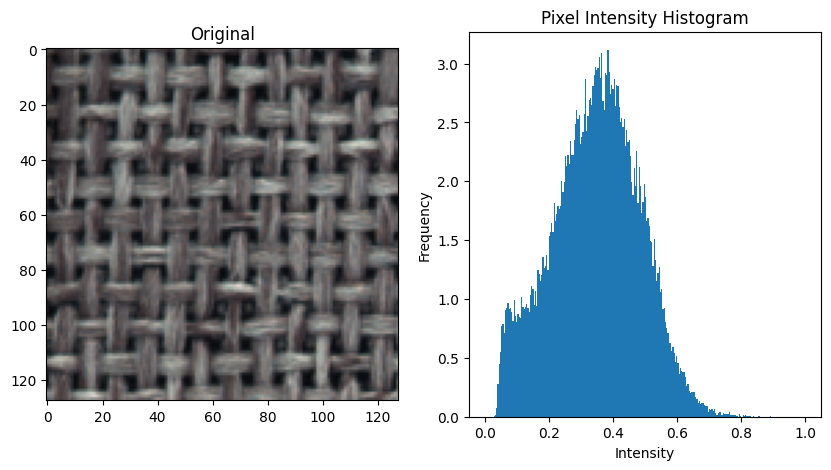

Intensity Range of Sample Image:
Min Intensity: 0.02745098
Max Intensity: 0.89411765


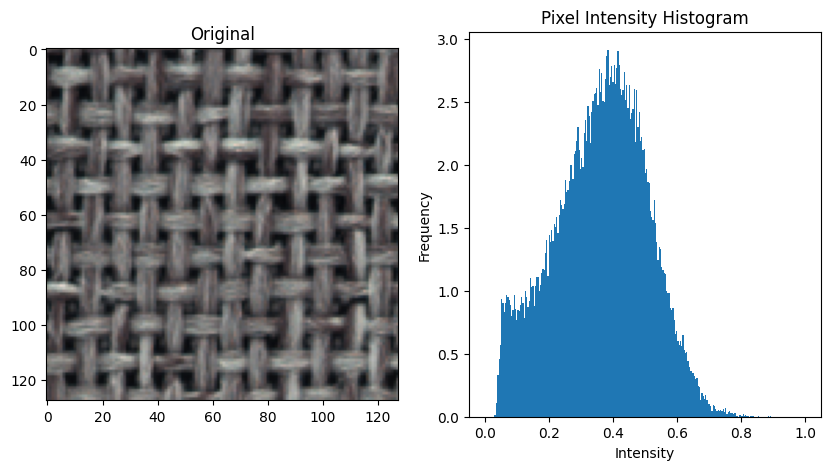

Intensity Range of Sample Image:
Min Intensity: 0.02745098
Max Intensity: 0.89411765


In [8]:
# Displaying the first image in the train generator batch

batches = train_generator[0]   # get batches
image_batch_1 = batches[0]      # get a batch of image patches

# print(train_generator.shape)
# print(len(train_generator[0]))
print(len(image_batch_1))
# print(first_image)

first_image = image_batch_1[0] 

# for i, element in enumerate(train_generator[0][0]):
#     print(f"Element {i}: type={type(element)}, shape={getattr(element, 'shape', 'No shape attribute')}")

for image in image_batch_1[0:2]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

    # img
    ax1.imshow(image)
    ax1.set_title('Original')
    # histogram
    ax2.hist(image.ravel(), bins=256, range=(0, 1), density=True)
    ax2.set_title('Pixel Intensity Histogram')
    ax2.set_xlabel('Intensity')
    ax2.set_ylabel('Frequency')

    plt.show()

    min_intensity = np.min(image)
    max_intensity = np.max(image)

    print("Intensity Range of Sample Image:")
    print("Min Intensity:", min_intensity)
    print("Max Intensity:", max_intensity)

model 

In [9]:
encoder_net = tf.keras.Sequential([
    InputLayer(input_shape=(SIZE, SIZE, 3)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),  # 64
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),  # 32
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),  # 16
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),  # 8
])

# Define the decoder with the new architecture
decoder_net = tf.keras.Sequential([
    InputLayer(input_shape=(8, 8, 16)),  # assuming the output shape of the encoder is (8, 8, 16)
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),  # 16
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),  # 32
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),  # 64
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),  # 128
    Conv2D(3, (3, 3), activation='sigmoid', padding='same')  # output layer with 3 channels
])


In [ ]:
print(encoder_net.summary())
print(decoder_net.summary())

Initialize outlier detector

In [10]:
od = OutlierAE(threshold=.0065,  # threshold for outlier score above which the element is flagged as an outlier.
                encoder_net=encoder_net,  # can also pass AE model instead of separate encoder and decoder
                decoder_net=decoder_net)  

In [11]:
adam = tf.keras.optimizers.Adam(learning_rate = 1e-3)

training

In [12]:
od.fit(image_batch_1,
       optimizer = adam,
       epochs=2,
       batch_size = batch_size,
       verbose=True)

294/294 [=] - 924s 3s/step - loss_ma: 0.0061


Testing

In [13]:
# test = validate_set.astype('float32') / 255.

# od.infer_threshold(test, outlier_type='instance', threshold_perc=99.0)
# print("Current threshold value is: ", od.threshold)

import os
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

bad_images_directory = r'G:\CO4001_eng_project\Dataset\carpet_512by512\test\hole'
bad_dataset = []
bad_images = os.listdir(bad_images_directory)

# print(len(bad_images))

for i, image_name in enumerate(bad_images):
    if image_name.endswith('.png'):
        image_path = os.path.join(bad_images_directory, image_name)
        image = cv2.imread(image_path)

        if image is not None:
            image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            bad_dataset.append(np.array(image))
        else:
            print(f"Failed to load image")

print(len(bad_dataset))
print(bad_dataset[0].shape)

bad_dataset = np.array(bad_dataset)
print(bad_dataset.shape)

fake = bad_dataset[:]
test_generator = DataGenerator(fake, patch_size, stride)


# Displaying the first image in the train generator batch

batches = test_generator[0]   # get batches
fake_image_batch_1 = batches[0]      # get a batch of image patches

# print(train_generator.shape)
# print(len(train_generator[0]))
print(len(fake_image_batch_1))
# print(first_image)

# first_image = fake_image_batch_1[0] 

# for i, element in enumerate(train_generator[0][0]):
#     print(f"Element {i}: type={type(element)}, shape={getattr(element, 'shape', 'No shape attribute')}")

# for i, image in enumerate(fake_image_batch_1[0:43]):
#     print(i)
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

#     # img
#     ax1.imshow(image)
#     ax1.set_title('Original')
#     # histogram
#     ax2.hist(image.ravel(), bins=256, range=(0, 1), density=True)
#     ax2.set_title('Pixel Intensity Histogram')
#     ax2.set_xlabel('Intensity')
#     ax2.set_ylabel('Frequency')

#     plt.show()

#     # min_intensity = np.min(image)
#     # max_intensity = np.max(image)

#     # print("Intensity Range of Sample Image:")
#     # print("Min Intensity:", min_intensity)
#     # print("Max Intensity:", max_intensity)



17
(512, 512, 3)
(17, 512, 512, 3)
833


Save Model

In [22]:
from alibi_detect.saving import save_detector

filepath = r'D:\sem 8\FYP_codes_CAE\Models\m2'
save_detector(od, filepath)

Directory D:\sem 8\FYP_codes_CAE\Models\m2\model does not exist and is now created.


d:\sem 8\FYP_codes_CAE\CAE\env\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
from alibi_detect.saving import load_detector
filepath = r'D:\sem 8\FYP_codes_CAE\Models\m3'
od1 = load_detector(filepath)

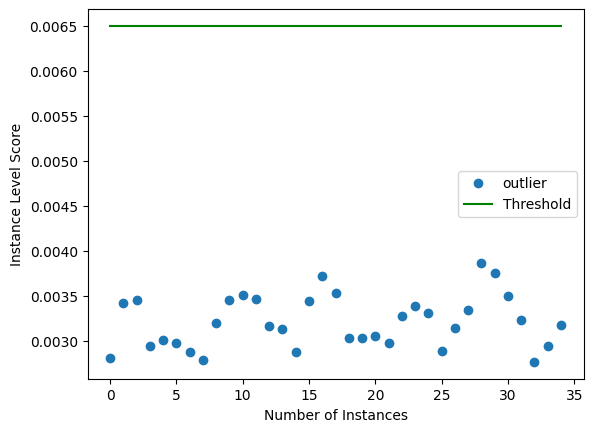

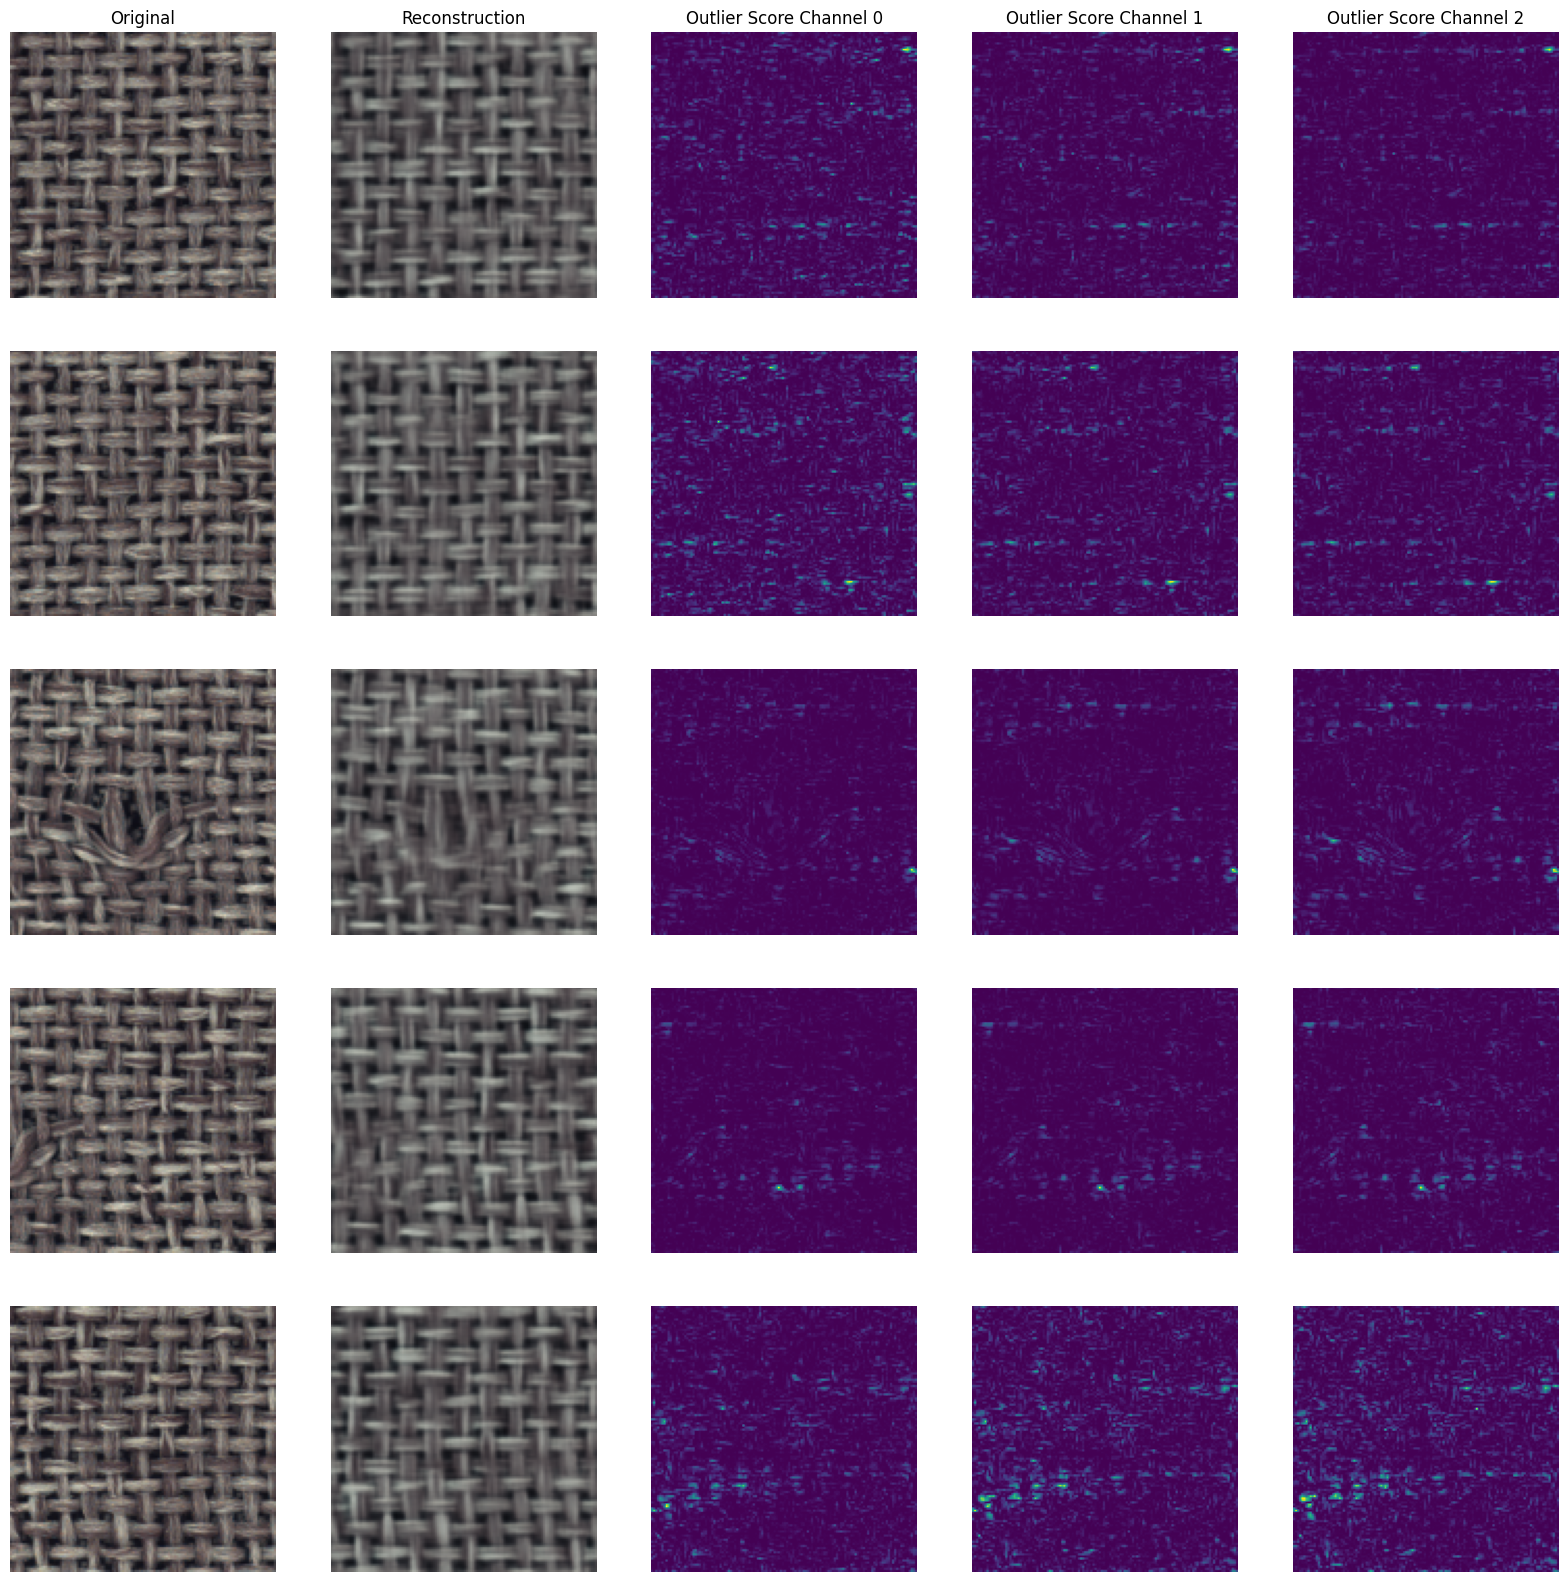

In [15]:
#check it for multiple images
test_set = fake_image_batch_1[:35]

od_preds = od1.predict(test_set,
                      outlier_type='instance',    # use 'feature' or 'instance' level
                      return_feature_score=True,  # scores used to determine outliers
                      return_instance_score=True)

from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image

#Scatter plot of instance scores. using the built-in function for the scatterplot. 
target = np.ones(test_set.shape[0],).astype(int)  # Ground truth (all ones for bad images)
labels = ['normal', 'outlier']
plot_instance_score(od_preds, target, labels, od1.threshold) #pred, target, labels, threshold
X_recon = od1.ae(test_set).numpy()

plot_feature_outlier_image(od_preds,
                           test_set,
                           X_recon=X_recon,
                           instance_ids=[26, 27, 29, 30, 31],  # pass a list with indices of instances to display
                           max_instances=5,  # max nb of instances to display
                           outliers_only=False)  # only show outlier predictions
